In [ ]:
import pandas as pd
import plotly.express as px
import regex as re
import stata_setup
stata_setup.config('/Applications/Stata/', 'mp', splash = False)
from pystata import stata
from sfi import Scalar

In [ ]:
# df = pd.read_clipboard()

In [ ]:
# df.columns

Index(['Location', 'Year', 'Price', 'Per', 'capita', 'Quantity'], dtype='object')

In [ ]:
# df.rename(columns={'Per': 'Qpc'}, inplace=True)

In [ ]:
# df.drop(columns=['capita', 'Quantity'], inplace=True)

In [ ]:
# df.columns = df.columns.str.lower()
# df.price = df.price.str.replace("$", "")
# df.price = pd.to_numeric(df.price)

/var/folders/95/4bt2x3vx4fj0ydsgs31kgl3r0000gn/T/ipykernel_89240/1806699921.py:2: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.



In [ ]:
df.to_csv("fixed_effect.csv", index = False)

In [ ]:
df = pd.read_csv("fixed_effect.csv")

In [ ]:
loc_dic = {'Chicago': 1, 'Peoria': 2, 'Milwaukee': 3, 'Madison': 4}
df['location_code'] = df.location.map(loc_dic)

In [ ]:
df

,location,year,price,qpc,location_code
0,Chicago,2003,75,2.0,1
1,Chicago,2004,85,1.8,1
2,Peoria,2003,50,1.0,2
3,Peoria,2004,48,1.1,2
4,Milwaukee,2003,60,1.5,3
5,Milwaukee,2004,65,1.4,3
6,Madison,2003,55,0.8,4
7,Madison,2004,60,0.7,4


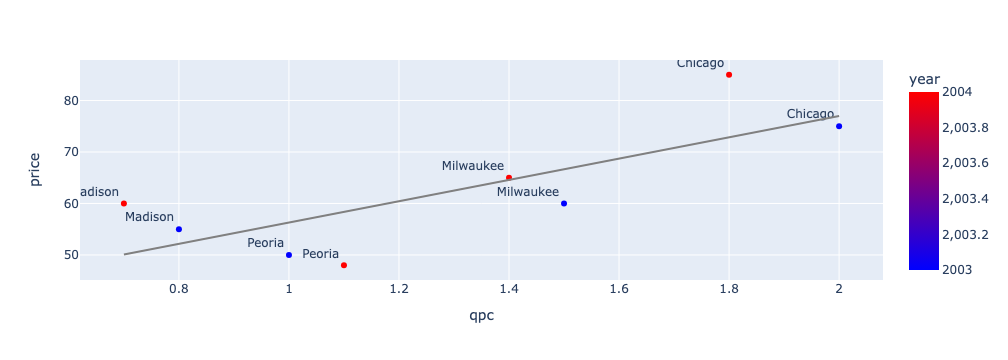

In [ ]:
fig = px.scatter(df, x="qpc", y="price", color = 'year', color_continuous_scale=['blue', 'red'], text = "location", trendline = 'ols', trendline_color_override = 'grey' )
fig.update_traces(textposition='top left')
fig.update(layout_showlegend=False)
fig.show()

In [ ]:
stata.pdataframe_to_data(df, force=True)
stata.run('reg price qpc', quietly = False)


      Source |       SS           df       MS      Number of obs   =         8
-------------+----------------------------------   F(1, 6)         =      8.74
       Model |  654.221177         1  654.221177   Prob > F        =    0.0254
    Residual |  449.278823         6  74.8798038   R-squared       =    0.5929
-------------+----------------------------------   Adj R-squared   =    0.5250
       Total |      1103.5         7  157.642857   Root MSE        =    8.6533

------------------------------------------------------------------------------
       price | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
         qpc |   20.68684   6.998647     2.96   0.025     3.561762    37.81191
       _cons |    35.6157   9.515973     3.74   0.010     12.33095    58.90045
------------------------------------------------------------------------------


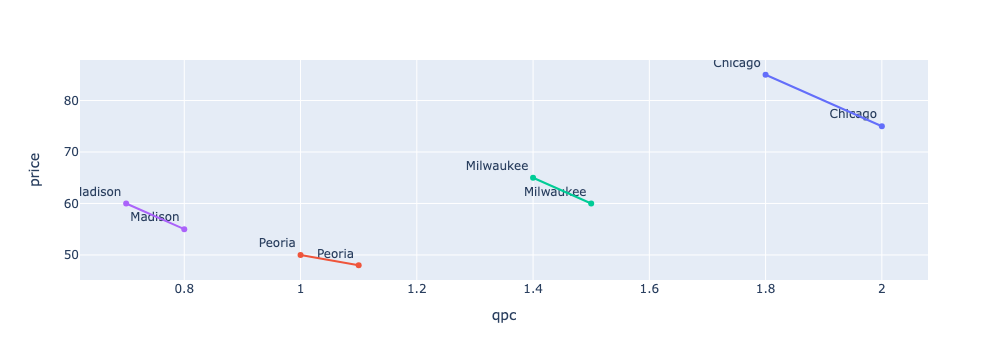

In [ ]:
fig = px.scatter(df, x="qpc", y="price", color = 'location', color_continuous_scale=['blue', 'red'], text = "location", trendline = 'ols')
fig.update_traces(textposition='top left')
fig.update(layout_showlegend=False)
fig.show()

In [ ]:
betas = []
locations = []
constants = []

#how would we simulate the above ?
for city in df.location.unique():
  dat = df[df.location == city]
  #print(city)
  stata.pdataframe_to_data(dat, force=True)
  stata.run('reg price qpc', quietly = True)
  stata.run('scalar beta = _b[qpc]')
  stata.run('scalar con = _b[_cons]')
  betas.append(Scalar.getValue('beta'))
  constants.append(Scalar.getValue('con'))
  locations.append(city)
loc_slopes = pd.DataFrame(list(zip(betas, locations, constants)),
               columns =['beta', 'loc', 'con'])

print('avg slope: ', loc_slopes.beta.mean())
print('avg intercept: ', loc_slopes.con.mean())
loc_slopes

avg slope:  -42.49999999999998
avg intercept:  118.75


,beta,loc,con
0,-50.0,Chicago,175.0
1,-20.0,Peoria,70.0
2,-50.0,Milwaukee,135.0
3,-50.0,Madison,95.0


In [ ]:
stata.pdataframe_to_data(df, force=True)
stata.run('reghdfe price qpc, absorb(location)')
stata.run('reg price qpc i.location_code')

(MWFE estimator converged in 1 iterations)

HDFE Linear regression                            Number of obs   =          8
Absorbing 1 HDFE group                            F(   1,      3) =      56.89
                                                  Prob > F        =     0.0048
                                                  R-squared       =     0.9965
                                                  Adj R-squared   =     0.9918
                                                  Within R-sq.    =     0.9499
                                                  Root MSE        =     1.1339

------------------------------------------------------------------------------
       price | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
         qpc |  -45.71429   6.060915    -7.54   0.005    -65.00282   -26.42575
       _cons |   121.1071   7.813719    15.50   0.001      96.2404    145.9739
-------

In [ ]:
%%stata
summarize


    Variable |        Obs        Mean    Std. dev.       Min        Max
-------------+---------------------------------------------------------
    location |          0
        year |          8      2003.5    .5345225       2003       2004
       price |          8       62.25    12.55559         48         85
         qpc |          8      1.2875    .4673252         .7          2


In [ ]:
%%stata
reg price qpc
**, cluster(location)
**#or vce(cluster cntry_iso3)  in rghdfe



. reg price qpc 

      Source |       SS           df       MS      Number of obs   =         8
-------------+----------------------------------   F(1, 6)         =      8.74
       Model |  654.221177         1  654.221177   Prob > F        =    0.0254
    Residual |  449.278823         6  74.8798038   R-squared       =    0.5929
-------------+----------------------------------   Adj R-squared   =    0.5250
       Total |      1103.5         7  157.642857   Root MSE        =    8.6533

------------------------------------------------------------------------------
       price | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
         qpc |   20.68684   6.998647     2.96   0.025     3.561762    37.81191
       _cons |    35.6157   9.515973     3.74   0.010     12.33095    58.90045
------------------------------------------------------------------------------

. **, cluster(location) 
. **#o

In [ ]:
betas = []
years = []
constants = []

#how would we simulate the above ?
for city in df.year.unique():
  dat = df[df.year == city]
  #print(city)
  stata.pdataframe_to_data(dat, force=True)
  stata.run('reg price qpc', quietly = True)
  stata.run('scalar beta = _b[qpc]')
  stata.run('scalar con = _b[_cons]')
  betas.append(Scalar.getValue('beta'))
  constants.append(Scalar.getValue('con'))
  years.append(city)
year_slopes = pd.DataFrame(list(zip(betas, years, constants)),
               columns =['beta', 'loc', 'con'])

print('avg slope: ', year_slopes.beta.mean())
print('avg intercept: ', year_slopes.con.mean())
year_slopes

avg slope:  21.76036355575261
avg intercept:  34.35790290401241


,beta,loc,con
0,18.443804,2003,35.561960
1,25.076923,2004,33.153846


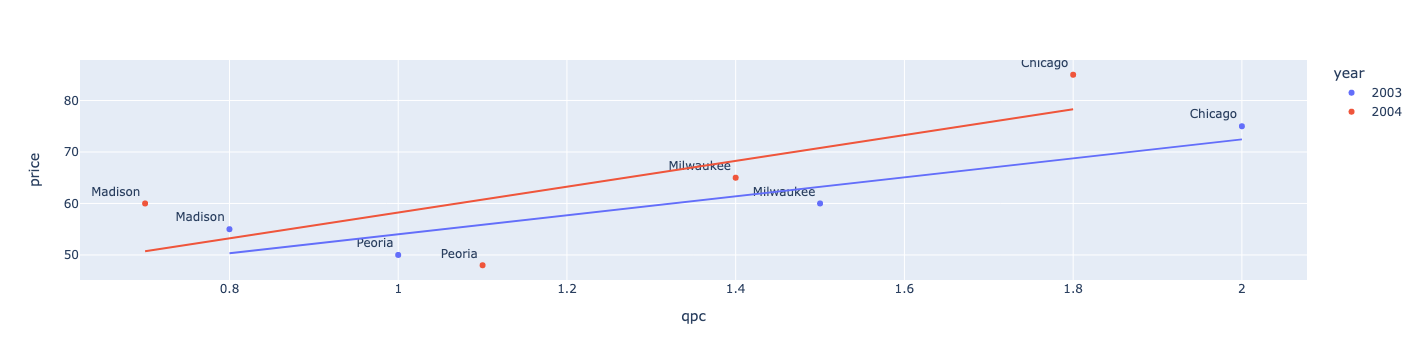

In [ ]:
dat = df.copy()
dat["year"] = dat["year"].astype(str)
fig = px.scatter(dat, x="qpc", y="price", color = 'year', text = "location", trendline = 'ols')
fig.update_traces(textposition='top left')

fig.show()

In [ ]:
stata.pdataframe_to_data(df, force=True)
stata.run('reghdfe price qpc, absorb(year)')
stata.run('reg price qpc i.year')

(MWFE estimator converged in 1 iterations)

HDFE Linear regression                            Number of obs   =          8
Absorbing 1 HDFE group                            F(   1,      5) =       9.15
                                                  Prob > F        =     0.0292
                                                  R-squared       =     0.6597
                                                  Adj R-squared   =     0.5236
                                                  Within R-sq.    =     0.6468
                                                  Root MSE        =     8.6660

------------------------------------------------------------------------------
       price | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
         qpc |   21.28501   7.034809     3.03   0.029     3.201457    39.36856
       _cons |   34.84555   9.561502     3.64   0.015     10.26693    59.42418
-------

In [ ]:
stata.pdataframe_to_data(df, force=True)
stata.run('reghdfe price qpc, absorb(year location)')


(MWFE estimator converged in 2 iterations)

HDFE Linear regression                            Number of obs   =          8
Absorbing 2 HDFE groups                           F(   1,      2) =     152.11
                                                  Prob > F        =     0.0065
                                                  R-squared       =     0.9996
                                                  Adj R-squared   =     0.9985
                                                  Within R-sq.    =     0.9870
                                                  Root MSE        =     0.4867

------------------------------------------------------------------------------
       price | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
         qpc |  -38.94737   3.157895   -12.33   0.007    -52.53469   -25.36004
       _cons |   112.3947   4.069429    27.62   0.001      94.8854    129.9041
-------

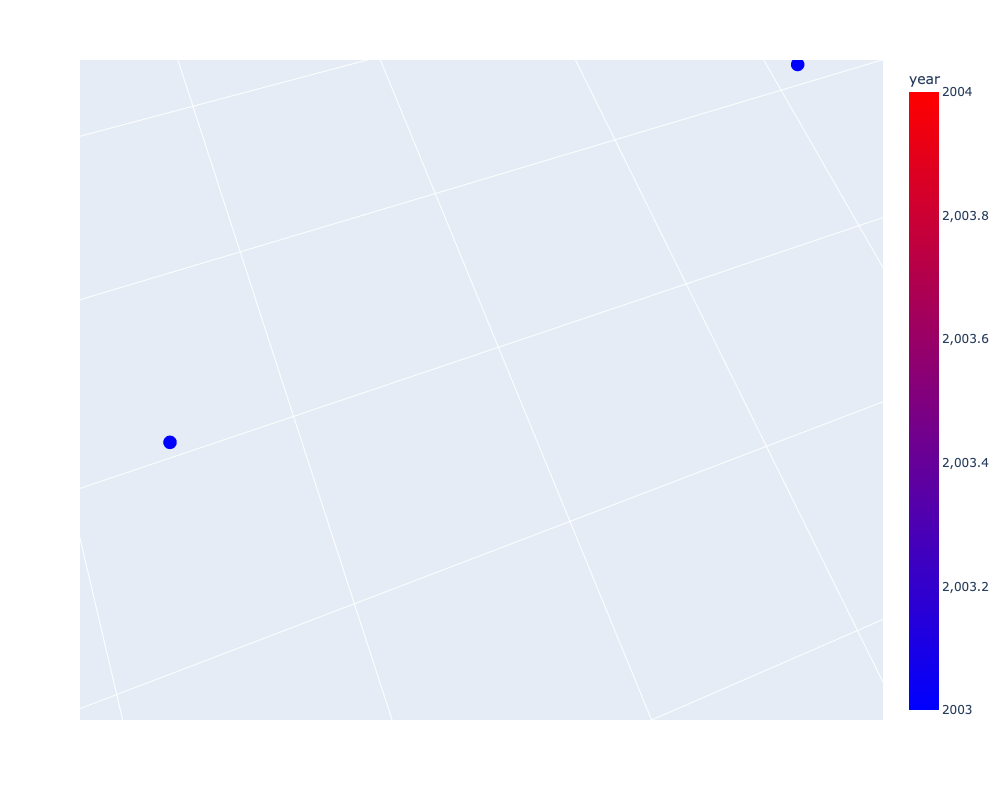

In [ ]:
fig = px.scatter_3d(df, x='qpc', y='price' , z='year',
              color='year', color_continuous_scale=['blue', 'red'])
fig.update_layout(
    autosize=False,
    width=800,
    height=800)
fig.show()

In [ ]:
import numpy as np

print(np.log(20000))
print(np.log(25000))
print(np.log(200000))
print(np.log(205000))

9.903487552536127
10.126631103850338
12.206072645530174
12.230765258120545


In [ ]:
print(np.log(25000) - np.log(20000))
print(np.log(205000) - np.log(200000))

0.2231435513142106
0.024692612590371255


In [ ]:
print(np.log(20000/25000))
print(np.log(200000/205000))

-0.2231435513142097
-0.02469261259037152


In [ ]:
(25000-20000)/20000

0.25

In [ ]:
(5000)/25000

0.2

In [ ]:
(5000)/200000

0.025

In [ ]:
(5000)/205000

0.024390243902439025